In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import math
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [3]:
df = pd.read_csv('preprocessed(MinMax).csv')
df

,age,campaign,day,previous,0,1,2,4,6,8,...,12,14,16,job_0,job_1,job_2,job_3,month_1,month_3,y
0,0.337662,0.000000,0.800000,0.000000,-0.313533,1.394495,0.000000,1.0,0.0,0.0,...,0.0,0.0,0.0,0,1,0,0,0,0,0
1,0.311688,0.081633,0.500000,0.000000,-0.215817,0.633028,0.000000,1.0,0.0,0.0,...,0.0,0.0,0.0,0,0,1,1,0,1,0
2,0.480519,0.020408,0.333333,0.000000,-0.219332,0.206422,0.000000,1.0,0.0,1.0,...,0.0,0.0,0.0,0,0,0,1,0,0,0
3,0.246753,0.061224,0.733333,0.000000,0.075923,0.100917,0.000000,1.0,0.0,0.0,...,1.0,1.0,0.0,0,1,0,1,0,1,0
4,0.207792,0.000000,0.266667,0.003636,-0.024605,0.417431,29.454545,1.0,0.0,0.0,...,1.0,1.0,0.0,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30902,0.714286,0.000000,0.533333,0.029091,1.671002,0.545872,3.727273,1.0,0.0,0.0,...,0.0,0.0,0.0,1,0,0,1,1,0,1
30903,0.090909,0.020408,0.533333,0.000000,0.022496,0.940367,0.000000,0.0,0.0,0.0,...,0.0,1.0,0.0,0,0,1,1,1,0,1
30904,0.428571,0.040816,0.533333,0.000000,0.247452,3.651376,0.000000,1.0,0.0,1.0,...,0.0,0.0,0.0,0,0,1,1,1,0,1
30905,0.688312,0.020408,0.533333,0.000000,0.882953,1.261468,0.000000,0.0,1.0,0.0,...,0.0,0.0,0.0,1,0,0,1,1,0,1


In [4]:
# 정상/이상 구분
normal = df.loc[df['y'] == 0]
anomaly = df.loc[df['y'] == 1]

# 행 shuffle 후 위에서 4513개 --> test
normal_shuffled=normal.sample(frac=1, random_state=3).reset_index(drop=True) #shuffling
normal_shuffled_test = normal_shuffled[:4513]
normal_shuffled_train = normal_shuffled[4513:]

# train에 쓰이는 정상 데이터 X, Y 구분
X_train = normal_shuffled_train[normal_shuffled_train.columns.difference(['y'])]
Y_train = normal_shuffled_train["y"]

# test에 쓰이는 정상 데이터 X, Y 구분 (샘플링)
X_normal_shuffled_test = normal_shuffled_test[normal_shuffled_test.columns.difference(['y'])]
Y_normal_shuffled_test = normal_shuffled_test["y"]

# test에 쓰이는 이상 데이터 X, Y 구분
X_anomaly = anomaly[anomaly.columns.difference(['y'])]
y_anomaly = anomaly["y"]

X_test = pd.concat([X_normal_shuffled_test, X_anomaly])
Y_test = pd.concat([Y_normal_shuffled_test, y_anomaly])

X_train.columns

Index(['0', '1', '10', '12', '14', '16', '2', '4', '6', '8', 'age', 'campaign',
       'day', 'job_0', 'job_1', 'job_2', 'job_3', 'month_1', 'month_3',
       'previous'],
      dtype='object')

In [5]:
trainset = pd.concat([X_train,Y_train],axis = 1)
testset = pd.concat([X_test,Y_test],axis = 1)
X_pr = pd.concat([X_train, X_test],axis=0)
dataset = pd.concat([trainset,testset],axis = 0)

Normal = dataset.loc[dataset['y'] == 0]
Anomaly = dataset.loc[dataset['y'] == 1]

In [6]:
from sklearn.svm import OneClassSVM
from collections import Counter

oneclassSVM 설명
  - kernel: 사용할 kernel 이름
  - nu: 얼마만큼 이상치를 잡아낼 것인 지.0~1사이의 값을 가지며, 학습에러의 상한비율, support vector의 하한비율을 나타냄
      - 값이 클수록 많은 이상치를 탐지(정상을 비정상으로 예측하는 경우가 많아짐)
  - gamma: RBF의 파라미터로 `값이 클수록` 낮은 sigma를 나타내며(sigma의 역수여서) 낮은 sigma일수록 뾰족한 가우시안 distribution 나타내고 `overfitting`하는 경향이 있음
      - `auto`는 gamma를 `1/n_features`로 정의함

In [7]:
oneSVM_model = OneClassSVM(nu=0.15, kernel="rbf", gamma='auto')
oneSVM_model = oneSVM_model.fit(X_train)

In [8]:
from sklearn.model_selection import GridSearchCV

In [9]:
# -1: 비정상(outliers)  1: 정상(inliers) 
results = oneSVM_model.predict(X_train)
from collections import Counter
Counter(results)

Counter({1: 18597, -1: 3284})

In [10]:
# test data에 대한 예측 값(-1: 비정상(outliers)  1: 정상(inliers) ) ->(정상=0, 이상=1)
oneSVM_test_pred = pd.DataFrame(oneSVM_model.predict(X_test))
oneSVM_test_pred = oneSVM_test_pred.replace({-1: 1, 1: 0})
oneSVM_test_pred

,0
0,1
1,0
2,0
3,0
4,0
...,...
9021,1
9022,0
9023,1
9024,0


In [11]:
def calculate_metric(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    tp, fn, fp, tn = cm.ravel()
    
    frr = fp / (fp + tn)
    far = fn / (fn + tp) 
    
    f1 = f1_score(y_true, y_pred)

    sns.heatmap(pd.DataFrame(cm, columns = ['Predicted', 'Actual']),
            xticklabels=['Abnormal [1]', 'Normal [0]'], 
            yticklabels=['Abnormal [1]', 'Normal [0]'], 
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
    return frr, far, f1

**  FRR: 0.1445  |  FAR: 0.6113  |  F1 Score: 0.507


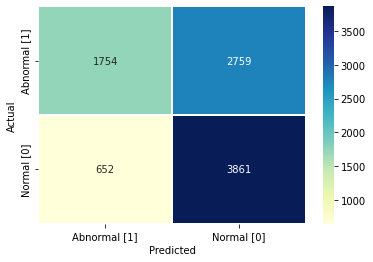

In [12]:
# test 평가
frr, far, f1 = calculate_metric(Y_test, oneSVM_test_pred)

print("**  FRR: {}  |  FAR: {}  |  F1 Score: {}".format(round(frr, 4), round(far, 4), round(f1, 4)))

In [13]:
# 각 샘플들의 이상치 스코어 (클수록 비정상)
oneSVM_train = oneSVM_model.score_samples(X_train)
oneSVM_test = oneSVM_model.score_samples(X_test)

Text(0.5, 1.0, 'Test Data')

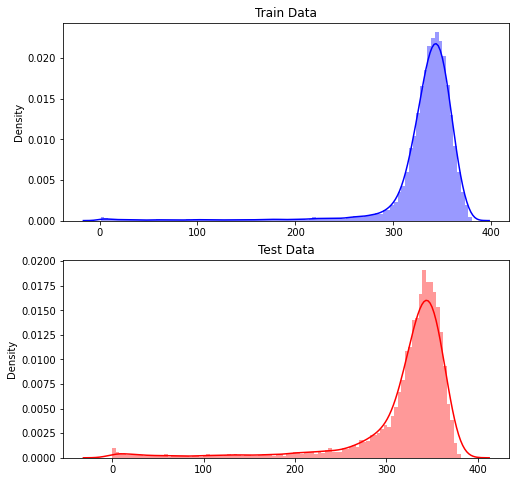

In [14]:
# train/test 데이터의 anomaly score 분포 시각화
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (8, 8))

sns.distplot(oneSVM_train, bins=100, kde=True, color='blue', ax=ax1)
sns.distplot(oneSVM_test, bins=100, kde=True, color='red', ax=ax2)
ax1.set_title("Train Data")
ax2.set_title("Test Data")

In [15]:
# threshold 탐색
# score의 min ~ max 범위를 num_step개로 균등 분할한 threshold에 대하여 best threshold 탐색 
def search_best_threshold(score, y_true, num_step):
    best_f1 = 0.5
    best_threshold = None
    for threshold in np.linspace(min(score), max(score), num_step):
        y_pred = threshold < score

        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    print('Best threshold: ', round(best_threshold, 4))
    print('Best F1 Score:', round(best_f1, 4))
    return best_threshold

In [16]:
# best threshold 도출
oneSVM_best_threshold = search_best_threshold(oneSVM_test, Y_test, num_step=1000)

Best threshold:  0.0
Best F1 Score: 0.6666


In [17]:
oneSVM_scores = pd.DataFrame()
oneSVM_scores['score'] = list(np.hstack([oneSVM_train, oneSVM_test]))
oneSVM_scores['score'].describe()

count    30907.000000
mean       327.324538
std         50.734150
min          0.000000
25%        324.111351
50%        338.993989
75%        350.776344
max        380.950837
Name: score, dtype: float64

In [21]:
from sklearn.linear_model import SGDOneClassSVM
sgd_oneSVM_model = SGDOneClassSVM(nu=0.15)
sgd_oneSVM_model = sgd_oneSVM_model.fit(X_train)

In [ ]:
grid_params = {'gamma': [1,0.1,0.01,0.001],
               'kernel': ['rbf', 'poly', 'sigmoid']}

svm_gs = GridSearchCV(OneClassSVM(), param_grid=grid_params, scoring='precision',cv=3, n_jobs = -1)
g_res = svm_gs.fit(X_train,Y_train)